In [4]:
import tensorflow as tf
tf.compat.v1.disable_eager_execution()
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline



In [5]:
file_path = 'HCM.csv'
data=pd.read_csv(file_path, delimiter=',',header=9,skipinitialspace=True)
data

,timestamp,Temperature,Precipitation,Wind Speed,Wind Direction
0,20200531T0000,27.083208,0.0,6.080693,151.18921
1,20200531T0100,26.723207,0.0,6.213462,149.03624
2,20200531T0200,26.303207,0.0,5.619714,148.57043
3,20200531T0300,25.923206,0.0,5.124306,152.10272
4,20200531T0400,25.633207,0.0,5.026425,147.99461
...,...,...,...,...,...
355,20200614T1900,27.773207,0.0,5.986595,159.14554
356,20200614T2000,27.563208,0.0,5.026425,147.99461
357,20200614T2100,27.483208,0.0,3.960321,137.72630
358,20200614T2200,27.113207,0.0,3.786256,129.28940


In [6]:
temperature = np.array(data['Temperature'])
num_periods = 12
f_horizon = 1
x_data = temperature[11:(len(temperature)-f_horizon)]
x_batches = x_data.reshape(-1, num_periods, 1)

y_data = temperature[12:(len(temperature))]
y_batches = y_data.reshape(-1, num_periods, 1)
print(y_batches.shape)

(29, 12, 1)


In [7]:
def test_data(series, forecast, num):
    testX = temperature[-(num + forecast):][:num].reshape(-1, num_periods, 1)
    return testX
X_test = test_data(temperature, f_horizon, 12*2)
print(X_test.shape)


(2, 12, 1)


In [8]:
tf.compat.v1.reset_default_graph()
inputs = 1
rnn_size = 100
output = 1
learning_rate=0.001
dropout_keep_prob = tf.compat.v1.placeholder(tf.float32)

X = tf.compat.v1.placeholder(tf.float32, [None, num_periods, 1])
Y = tf.compat.v1.placeholder(tf.float32, [None, num_periods, 1])

rnn_cells=tf.compat.v1.nn.rnn_cell.BasicRNNCell(num_units=rnn_size, activation=tf.nn.relu6)
rnn_output, states = tf.compat.v1.nn.dynamic_rnn(rnn_cells, X, dtype=tf.float32)

output=tf.reshape(rnn_output, [-1, rnn_size])
logit=tf.compat.v1.layers.dense(output, 1, name="softmax")

outputs=tf.reshape(logit, [-1, num_periods, 1])
print(logit)

loss = tf.reduce_sum(input_tensor=tf.square(outputs - Y))

accuracy = tf.reduce_mean(input_tensor=tf.cast(tf.equal(tf.argmax(input=logit, axis=1), tf.cast(Y, tf.int64)), tf.float32))

optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate=learning_rate)
train_step=optimizer.minimize(loss)

init=tf.compat.v1.global_variables_initializer()

Instructions for updating:
This class is equivalent as tf.keras.layers.SimpleRNNCell, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API
Instructions for updating:
Please use `layer.add_weight` method instead.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Use keras.layers.Dense instead.
Instructions for updating:
Please use `layer.__call__` method instead.
Tensor("softmax/BiasAdd:0", shape=(None, 1), dtype=float32)


In [9]:
epochs = 1000

sess = tf.compat.v1.Session()
init = tf.compat.v1.global_variables_initializer()
sess.run(init)
saver = tf.compat.v1.train.Saver()

for epoch in range(epochs):
    train_dict = {X: x_batches, Y: y_batches, dropout_keep_prob:0.5}
    sess.run(train_step, feed_dict=train_dict)
y_pred=sess.run(outputs, feed_dict={X: X_test})
save_path = saver.save(sess, "models/HCM.ckpt")


In [10]:
with tf.compat.v1.Session() as sess:
  # Restore variables from disk.
    saver = tf.compat.v1.train.Saver()
    saver.restore(sess, "models/HCM.ckpt")
    y_pred=sess.run(outputs, feed_dict={X: X_test})
    print (y_pred)

INFO:tensorflow:Restoring parameters from models/HCM.ckpt
[[[26.695232]
  [25.503632]
  [25.391632]
  [25.306332]
  [25.320957]
  [25.525993]
  [26.094994]
  [28.048054]
  [29.117865]
  [29.399368]
  [30.372623]
  [31.811567]]

 [[30.712128]
  [31.171688]
  [30.273945]
  [29.767632]
  [29.175274]
  [29.500645]
  [28.681953]
  [28.297192]
  [27.670315]
  [27.096138]
  [26.938557]
  [27.098785]]]


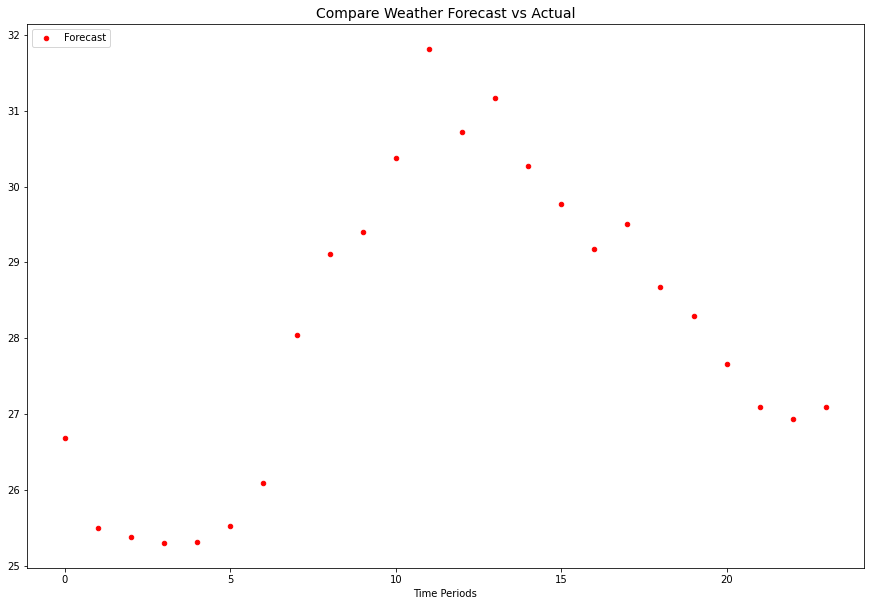

In [11]:
plt.figure(figsize=(15,10))
plt.title("Compare Weather Forecast vs Actual", fontsize=14)
plt.plot(pd.Series(np.ravel(y_pred)),"r.",  markersize=9, label="Forecast")
plt.legend(loc="upper left")
plt.xlabel("Time Periods")
plt.show()
